In [1]:
#!pip install --upgrade keras

import sys
import keras
from keras import backend as K
import os
from PIL import Image
from keras.models import load_model
import matplotlib.patches as patches
from matplotlib import pyplot


print('Keras version:',keras.__version__)

# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)


Using TensorFlow backend.


Keras version: 2.2.4
0.0.9


In [2]:
def load_facenet_model():
    # load the model
    model_path = "/faceml/keras-facenet/model/facenet_keras.h5"
    model = load_model(model_path)
    model.load_weights('/faceml/keras-facenet/weights/facenet_keras_weights.h5')
    # summarize input and output shape
    print(model.inputs)
    print(model.outputs)
    return model

In [12]:
from PIL import Image, ImageOps 
from numpy import asarray
from mtcnn.mtcnn import MTCNN

def load_image(filename):
    try:
        image = Image.open(filename)
        #image = resize_image(image,(160,160))
        # convert to RGB, if needed
        image = image.convert('RGB')
        # convert to array
        pixels = asarray(image)
        return pixels
    except:
        return None
    
def addMargin(startX,startY,endX,endY,margin):
    startX = int(startX - (startX*margin/100))
    endX = int(endX + (endX*margin/100))
    startY = int(startY - (startY*margin/100))
    endY = int(endY + (endY*margin/100))
    return startX,startY,endX,endY
            
def extract_face(detector, filename, margin):    
    x1,y1,x2,y2,faces, pixels = extract_all_faces(detector, filename, margin)
    if (faces is None or len(faces)==0):
        return (None,)*5,pixels
    return x1[0],y1[0],x2[0],y2[0],faces[0],pixels    

# extract a single face from a given photograph
def extract_all_faces(detector, filename, margin, required_size=(160, 160)):
    print(filename)
    x1,y1,x2,y2 = list(),list(),list(),list()
    faces=list()
    # load image from file
    # convert to array
    pixels = load_image(filename)
    if (pixels is None):
        return None,None,None,None,None,pixels
    # detect faces in the image
    results = detector.detect_faces(pixels)
   # extract the bounding box from the first face
    if (len(results) > 0):
        for i in range(len(results)):
            startX=results[i]['box'][0]
            startY=results[i]['box'][1]
            endX=startX + results[i]['box'][2]
            endY= startY + results[i]['box'][3]
            #x1[i], y1[i], width, height = results[i]['box']
            # bug fix
            startX,startY = abs(startX), abs(startY)
            # extract the face
            if margin > 0:
                startX,startY,endX,endY = addMargin(startX,startY,endX,endY,margin)

            face = pixels[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]
            #print(i, x,y,width,height,fH,fW)
            if fW < 10 or fH < 10:
                continue
            x1.append(startX)
            y1.append(startY)
            x2.append(endX)
            y2.append(endY)
            # resize pixels to the model size
            image = Image.fromarray(face)
            image = image.resize(required_size)
            face_array = asarray(image)
            faces.append(face_array)
        return x1, y1, x2, y2, faces, pixels
    else:
        return None,None,None,None,None,pixels

def resize_image(src_image, size=(128,128)): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

def resize_image_arr(src_image, size=(128,128)):
     image = Image.fromarray(src_image)
     return asarray(resize_image(image, size))


In [4]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    #print("samples:",samples.shape)
    # make prediction to get embedding
    yhat = model.predict(samples)
    #print("yhat:",yhat.shape, yhat[0])
    return yhat[0]

# load the facenet model
model = load_facenet_model()
print('Loaded Model')


/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]
Loaded Model


In [5]:
def show_image(im, x1, y1, x2, y2):
    fig,ax = pyplot.subplots(1)
    pyplot.figure(figsize=(320,320))
    ax.imshow(im)
    if (x1 is None):
        return
    for i in range(len(x1)):
        rect = patches.Rectangle((x1[i],y1[i]),x2[i]-x1[i],y2[i]-y1[i],linewidth=1,edgecolor='r',facecolor='none', label=i)
        centerx = x1[i] + (x2[i]-x1[i])/2
        centery = y1[i] + (y2[i]-y1[i])/2
        ax.text(centerx, centery,str(i))
        # Add the patch to the Axes
        ax.add_patch(rect)
    pyplot.show()

In [57]:
def retryPred(x1,y1,x2,y2,pixels,model,in_encoder,recognizer, required_size=(160, 160)):
    maxProb=0
    max_yhat_class=[]
    max_yhat_prob=[]
    for margin in (0,1,3,5):
        startX,startY,endX,endY = addMargin(x1,y1,x2,y2,margin)
        face = pixels[startY:endY,startX:endX]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = asarray(image)
        embedding = get_embedding(model,face_array)
        samples = in_encoder.transform(embedding.reshape(1,-1))
        yhat_class = recognizer.predict(samples)
        yhat_prob = recognizer.predict_proba(samples)
        # get name
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        if class_probability > maxProb:
            max_yhat_prob=yhat_prob
            max_yhat_class=yhat_class
            maxProb = class_probability
    return max_yhat_class, max_yhat_prob

/faceml/sampleimages/image1.jpg


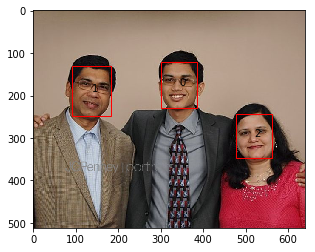

<Figure size 23040x23040 with 0 Axes>

Faces: 3
0 [[ 0.98076863  0.01660604  0.00262533]] ['atharva'] 98.0768631175
1 [[ 0.0025831   0.99613039  0.00128651]] ['samir'] 99.6130385127
2 [[ 0.0042196   0.00536336  0.99041704]] ['sangeeta'] 99.0417035919


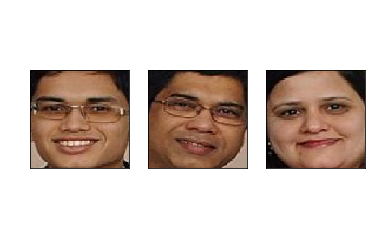

In [58]:
import matplotlib.patches as patches
from matplotlib import pyplot
from sklearn.preprocessing import Normalizer
import pickle
import math

recognizer_file = "/images/whatsapp/training/recognizer_keras.pickle"
labelencoder_file = "/images/whatsapp/training/labelencoder_keras.pickle"
recognizer = pickle.loads(open(recognizer_file, "rb").read())
out_encoder = pickle.loads(open(labelencoder_file, "rb").read())

image_file='/faceml/sampleimages/image1.jpg'

detector = MTCNN()
x1, y1, x2, y2, faces, pixels = extract_all_faces(detector, image_file,0)
show_image(load_image(image_file),x1, y1, x2, y2)
in_encoder = Normalizer(norm='l2')
if not faces is None:
    cols = min(5,len(faces))
    rows = math.ceil(len(faces)/cols)    
    fig,axes = pyplot.subplots(rows,cols)
    if (axes.ndim==1):
        axes=axes.reshape(1,-1)
    for i in range(rows):
        for j in range(cols):
            axes[i,j].axis("off")
    print("Faces:",len(faces))
    for i in range(len(faces)):
        s = fig.add_subplot(rows,cols,i+1)
        s.set_xticks(())
        s.set_yticks(())
        pyplot.imshow(faces[i])
        yhat_class, yhat_prob = retryPred(x1[i],y1[i],x2[i],y2[i],pixels,model,in_encoder,recognizer)
        # get name
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        predict_names = out_encoder.inverse_transform(yhat_class)
        print(i, yhat_prob, predict_names, class_probability)
else:
    print("No known faces found")
       
pyplot.show()